In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
class Obd(object):
    @staticmethod
    def loadFile(csv):
        names=["TIMESTAMP", "SPEED", "RPM", "THROTTLE_POS", "ENGINE_LOAD", "COOLANT_TEMP", "INTAKE_PRESSURE", "INTAKE_TEMP", "MAF", "DISTANCE_W_MIL", "FUEL_RAIL_PRESSURE_DIRECT", "O2_S1_WR_VOLTAGE", "GEAR"]
#        dtypes = {"TIMESTAMP": np.datetime64, "SPEED": np.float64, "RPM": np.float64, "THROTTLE_POS": np.float64, "ENGINE_LOAD": np.float64,
#                    "COOLANT_TEMP": np.int32, "INTAKE_PRESSURE": np.int32, "INTAKE_TEMP": np.int32, "MAF": np.float64,
#                    "DISTANCE_W_MIL": np.int32, "FUEL_RAIL_PRESSURE_DIRECT": np.int32, "O2_S1_WR_VOLTAGE": np.float64, "GEAR": np.int32}
        data = pd.read_csv(csv, sep=",", quotechar="'", skipinitialspace=True, parse_dates=[0], 
                           skiprows=1, skipfooter=1, index_col=False, names=names, engine="python")
        data["ts"] = data.iloc[:,0].apply(lambda x: int(x.to_pydatetime().timestamp()+7200))
        return data



In [3]:
class Nmea(object):
    
    @staticmethod
    def parse_gga(line):
        token = line.split(',')
        time_str = token[1]
        if time_str == '000000':
            return None
        lat = float(token[2][:2])+float(token[2][2:])/60.0
        lon = float(token[4][:3])+float(token[4][3:])/60.0
        fix = int(token[6])
        sat = int(token[7])
        hdop = float(token[8])
        alt = float(token[9])
        geo_hgt = float(token[11])
        return (time_str, lat, lon, fix, sat, hdop, alt, geo_hgt)
        
    @staticmethod
    def parse_rmc(line):
        #speed, heading
        token = line.split(',')
        time_str = token[1]
        if time_str == '000000':
            return None
        ts = int(token[0].split(' ')[0])
        speed = float(token[7]) * 1.852
        angle = float(token[8])
        timestamp = datetime.datetime(year=int(token[9][4:6])+2000, month=int(token[9][2:4]), day=int(token[9][0:2]), 
                                        hour=int(token[1][:2]), minute=int(token[1][2:4]), second=int(token[1][4:6]))
        return (time_str, ts, timestamp, speed, angle)
    
    @staticmethod
    def loadFile(txt):
        names = []
        rmc, gga = None, None
        data = []
        names = ['ts', 'timestamp', 'lon', 'lat', 'alt', 'speed', 'heading', 'fix', 'sat', 'hdop', 'geo_hgt']
        with open(txt, 'r') as f:
            for line in f.readlines():
                if '$GPRMC' in line:
                    rmc = Nmea.parse_rmc(line)
                elif '$GPGGA' in line:
                    gga = Nmea.parse_gga(line)
                if rmc and gga and rmc[0] == gga[0]:
                    data.append((rmc[1], rmc[2], gga[2], gga[1], gga[6], rmc[3], rmc[4], gga[3], gga[4], gga[5], gga[7]))
                    rmc, gga = None, None
        df = pd.DataFrame(data, columns=names)
        return df



In [4]:
class Pressure(object):
    @staticmethod
    def hyposometric_formula(pressure):
        """ hb = Ts/kT * [(pb/ps)^(R*kT/g0) - 1] + hs
            ps, Ts, hs = reference surface pressure and temperature in geodetic height
            R = 287,1 - gas constant
            kT = 6.5*10-3 - temperature gradient
            g0 = 9.80665
            For stand-alone barometry:
            ps = 101.325 kPa
            Ts = 288.15 K
            then hb-hs is orhometric height up to 10.769km
        """        
        return 288.15/0.0065 * ((1013.25/pressure)**(1/5.257)-1)

    @staticmethod
    def loadFile(csv):
        names=["ts", "temp", "press"]
        data = pd.read_csv(csv, delim_whitespace=True, dtype=np.float64, names=names, 
                           skipfooter=1, index_col=False, engine="python")
        data["height"] = data.iloc[:,2].apply(lambda x: Pressure.hyposometric_formula(x) )
        return data

In [5]:
import numpy as np

class KalmanFilter(object):
    A = None   # linear recursion coeficient
    C = None   # state to measurement scale factor
    P = None   # prediction error
    G = None   # recursion gain
    R = None   # sensor RMS error
    X = None   # estimated state
    Z = None   # measured state
    Q = None   # prediction covariance
    B = None   # system error scaling
    U = None   # bias, offset, system error

    def __init__(self):
        # x_k = A @ x_k-1 + B @ u_k
        self.A = None   # linear recursion coeficient
        self.P = None   # prediction error
        self.G = None   # recursion gain
        self.R = None   # sensor RMS error
        self.X = None   # estimated state
        self.Z = None   # measured state
        self.C = None   # scale factor
        self.Q = None   # prediction covariance (similar to R in measurement)
        self.B = None   # system error scaling
        self.U = None   # bias, offset, system error

    def _predict(self):
        self.X = self.A @ self.X + self.B @ np.nan_to_num(self.U)
        self.P = self.A @ self.P @ self.A.T + self.Q

    @staticmethod
    def _initial_measurement(measurement):
        return measurement
    
    @staticmethod
    def _foo_measurement(measurement):
        # if non-linear function Extended Kalman Filter has to be used !
        return measurement
        
    def update(self, measurement):
        if (self.X is None):
            self.X = self._initial_measurement(measurement)
            self.U = self._foo_measurement(measurement) - self.X
            return self.X
        self._predict()
        self.Z = self.C @ self._foo_measurement(measurement)
        self.U = self.Z - self.X
        self.G = self.P @ self.C.T @ np.linalg.inv(self.C @ self.P @self.C.T + self.R)
        self.G = np.nan_to_num(self.G + self.Z.T - self.Z.T)
        self.X = self.X + self.G @ (np.nan_to_num(self.Z) - self.C @ self.X)
        self.P = (np.identity(np.shape(self.C)[1]) - self.G @ self.C) @ self.P
        return self.X


class Bpm280Kalman(KalmanFilter):

    @staticmethod
    def height(pressure):
        """ hb = Ts/kT * [(pb/ps)^(R*kT/g0) - 1] + hs
            ps, Ts, hs = reference surface pressure and temperature in geodetic height
            R = 287,1 - gas constant
            kT = 6.5*10-3 - temperature gradient
            g0 = 9.80665
            For stand-alone barometry:
            ps = 101.325 kPa
            Ts = 288.15 K
            then hb-hs is orhometric height up to 10.769km
        """
        return 44330.7692307692 * ( 1 - np.power(pressure/1013.25, 0.1902949572))

    @staticmethod
    def _foo_measurement(measurement):
        return np.matrix(self.height(measurement))
    
    def __init__(self):
        self.A = np.matrix([[1.0]])
        self.P = np.matrix([[0.5]])
        self.R = np.matrix([[0.12]])
        self.C = np.matrix([[1.0]])
        self.Q = np.matrix([[0.000001]])  # smaller number = smoother result
        self.B = np.matrix([[0.0]])

    
class BpmGPSFusionKalmanFilter(KalmanFilter):
    """ Assumes the barometer state is converted to altitude. No raw pressure. """
    def __init__(self):
        self.A = np.matrix([[1.0]])
        self.C = np.matrix([[1.0, 1.0]])
        self.R = np.matrix([[1.0, 0.3], [0.3, 5.0]])   # 0.12 hPa or 1m, 5m for GPS
        self.P = np.matrix([[0.5]])
        self.Q = np.matrix([[0.000001]])  # smaller number = smoother result
        self.B = np.matrix([[0, 0.0]])
        
    @staticmethod
    def _initial_measurement(measurement):
        return np.matrix([[measurement[0,0]]])
        
    #def update(self, measurement):
        """ For a missing measurement, just use the last state estimate as a measurement 
            but set the covariance matrix of the measurement to essentially infinity. 
            (If the system uses inverse covariance just set the values to zero.) This would 
            cause a Kalman filter to essentially ignore the new measurement since the ratio 
            of the variance of the prediction to the measurement is zero. The result will be 
            a new prediction that maintains velocity/acceleration but whose variance will grow 
            according to the process noise.
        """
        
class BpmGpsFusionKF2(KalmanFilter):
    """ Assumes the barometer state is converted to altitude. No raw pressure. """
        # self.U - system error should be drived by the GPS measurement

    def __init__(self):
        self.A = np.matrix([[1.0]])
        self.P = np.matrix([[0.5]])
        self.R = np.matrix([[1.0]])
        self.C = np.matrix([[1.0]])
        self.Q = np.matrix([[0.1]])  # smaller number = smoother result
        self.B = np.matrix([[0.0]]) # maybe use the num of satelites to scale the bias in U
                
    @classmethod
    def _initial_measurement(cls, measurement):
        return measurement[[[0],[0]]]
        
    def _foo_measurement(self, measurement):
        return measurement[[[1],[0]]]

              ts           timestamp        lon        lat     alt      speed  \
0     1582268802 2020-02-21 07:06:43  19.603698  48.641347  910.99  32.367219   
1     1582268803 2020-02-21 07:06:44  19.603577  48.641362  910.96  33.314887   
2     1582268804 2020-02-21 07:06:45  19.603453  48.641378  910.46  33.475270   
3     1582268805 2020-02-21 07:06:46  19.603330  48.641395  909.83  33.527682   
4     1582268806 2020-02-21 07:06:47  19.603203  48.641415  909.15  34.559616   
5     1582268807 2020-02-21 07:06:48  19.603073  48.641433  908.64  35.208002   
6     1582268808 2020-02-21 07:06:49  19.602938  48.641455  907.84  37.118895   
7     1582268809 2020-02-21 07:06:50  19.602802  48.641473  906.99  36.582741   
8     1582268810 2020-02-21 07:06:51  19.602663  48.641490  906.35  37.286872   
9     1582268811 2020-02-21 07:06:52  19.602525  48.641507  905.31  37.243720   
10    1582268812 2020-02-21 07:06:53  19.602385  48.641520  904.59  37.164640   
11    1582268813 2020-02-21 

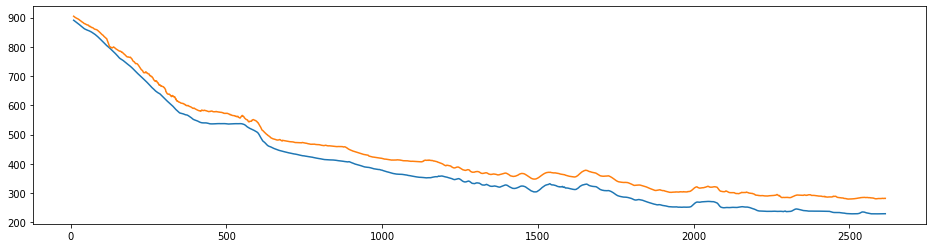

In [31]:
nmea = Nmea.loadFile("/Users/dorsic/Development/imu/data/G1582201125.nmea")
pres = Pressure.loadFile("/Users/dorsic/Development/imu/data/P1582268796.csv")

press_height = pres[['ts', 'height']].groupby(pres['ts'].apply(lambda x: int(round(x, 0)))).mean().drop(columns='ts')
mh = pd.merge(nmea, press_height, how='inner', left_on='ts', right_on='ts')


print(mh)
plt.figure(figsize=(16,4))
plt.plot(mh[['height', 'alt']][10:])

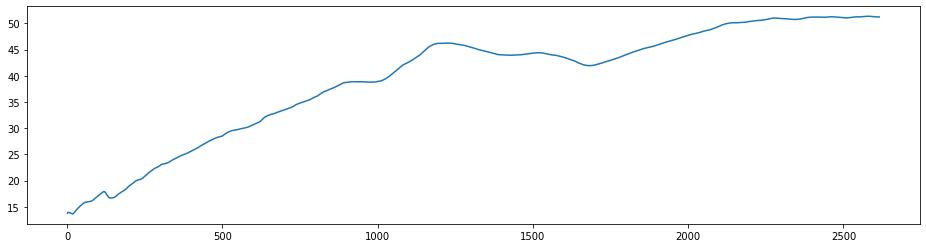

In [44]:

mh['baro_correction'] = mh['alt']-mh['height']
mh['baro_correction'] = mh['baro_correction'].rolling(500, min_periods=2).mean() 

mh[['ts', 'height', 'alt', 'baro_correction']]
mh['corected_height'] = mh['height'] + mh['baro_correction']

plt.figure(figsize=(16,4))
plt.plot(mh['baro_correction'])
#plt.plot(mh[['height', 'alt', 'corected_height']][600:1200])


In [ ]:
barometer_offset = 0.0
for idx, row in mh.iterrows():
    if row['ts'] >= gps.iloc[gidx,0]:
        gidx = gidx + 1
    row['g_alt'] = gps.iloc[gidx, 1]
    row['g_sat'] = gps.iloc[gidx, 4]


In [6]:
#obd = Obd.loadFile("/Users/dorsic/Development/imu/data/G1581459526.nmea")
nmea = Nmea.loadFile("/Users/dorsic/Development/imu/data/G1582201125.nmea")
pres = Pressure.loadFile("/Users/dorsic/Development/imu/data/P1582268796.csv")

#mg = pd.merge(nmea, obd, how='inner', left_on='ts', right_on='ts')

press_height = pres[['ts', 'height']].groupby(pres['ts'].apply(lambda x: int(round(x, 0)))).mean().drop(columns='ts')
mh = pd.merge(nmea, press_height, how='inner', left_on='ts', right_on='ts')


hkf = BpmGpsFusionKF2()

meas = mh[['ts', 'height', 'alt']]
meas.columns = ['ts', 'b_alt', 'g_alt']
meas['alt'] = meas.apply(lambda x: hkf.update( np.matrix([[x[1]], [x[2]]]) )[0,0], axis=1)

plt.figure(figsize=(16,4))
plt.plot(meas[['alt', 'b_alt', 'g_alt']])

IndexError: list index out of range

In [ ]:
gidx = 0
for idx, row in meas.iterrows():
    if row['ts'] >= gps.iloc[gidx,0]:
        gidx = gidx + 1
    row['g_alt'] = gps.iloc[gidx, 1]
    row['g_sat'] = gps.iloc[gidx, 4]

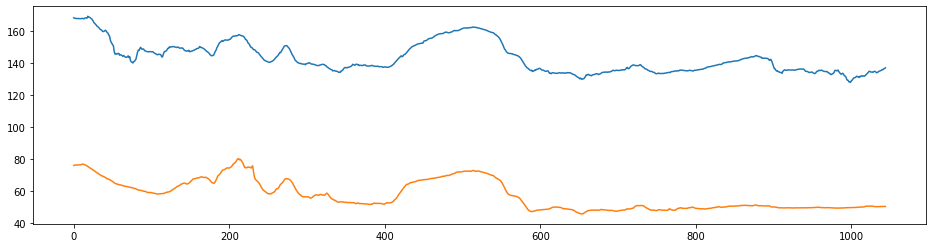

In [25]:
plt.figure(figsize=(16,4))
plt.plot(mh[['alt','height']])

<Figure size 1152x288 with 0 Axes>

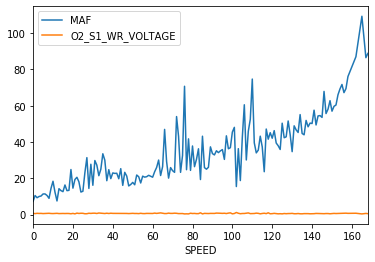

In [301]:
spd_map = mg[['SPEED', 'MAF', 'O2_S1_WR_VOLTAGE']].groupby(['SPEED']).mean()
spd_map.plot()

In [290]:
press_height = press[['TS', 'HEIGHT']].groupby(press['TS'].apply(lambda x: int(round(x, 0)))).mean().drop(columns='TS')

In [306]:
tst = pd.merge(mg, press_height, how='left', left_on='ts', right_on='TS')


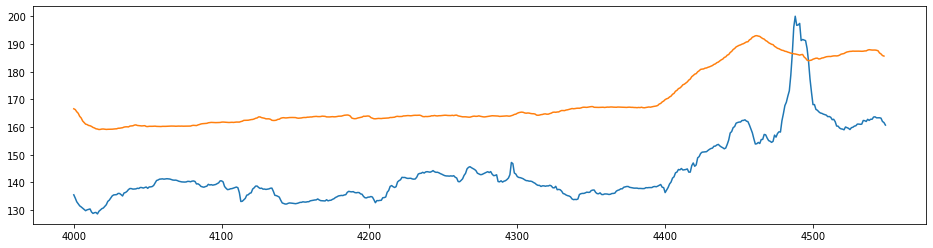

In [303]:
plt.figure(figsize=(16,4))
plt.plot(tst[['alt', 'HEIGHT']][4000:])